In [2]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import sys
import os
from keras.layers import Input, TimeDistributed, Lambda, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
import keras.backend as K
from keras.models import Model
import tensorflow as tf
from keras.utils import Sequence
from keras.optimizers import Adam
import cv2
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from PIL import Image
from IPython.display import clear_output
import scipy.io
from copy import deepcopy
import tqdm 
import math
import random

sys.path.append('src')

from data_loading import load_datasets_multiduration
from util import get_model_by_name, create_losses

# from eval import *
# from attentive_convlstm_new import AttentiveConvLSTM2D
# from dcn_resnet_new import dcn_resnet
# from gaussian_prior_new import LearningPrior
# from losses_keras2 import *
from sal_imp_utilities import *
from cb import InteractivePlot
from losses_keras2 import loss_wrapper
# #from multiduration_models import xception_3stream
# from multiduration_models import sam_xception_timedist, sam_resnet_timedist, xception_se_lstm
# from util import get_model_by_name

# from data_loading import load_datasets_multiduration, load_datasets_sal_imp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Check GPU status

In [2]:
%%bash
nvidia-smi

Thu Mar 28 04:45:35 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:02:00.0 Off |                  N/A |
| 32%   43C    P5    19W / 250W |      0MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   29C    P8     9W / 250W |      0MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["CUDA_VISIBLE_DEVICES"]

'0'

# Load data

In [4]:
# FILL THESE IN 
dataset = "codecharts"
bp = "/mnt/localssd2/predimportance/predimportance_shared/datasets"

In [5]:
times = [500, 3000, 5000]

data = load_datasets_multiduration(dataset, times, bp=bp, verbose=True)

avlb_times [500, 3000, 5000]
APPENDING IMAGES FOR TIME: 500
APPENDING IMAGES FOR TIME: 3000
APPENDING IMAGES FOR TIME: 5000
map_files_test : [250, 250, 250]
img_files_val: 50
map_files_train : [700, 700, 700]
fix_as_mat : False
fix_files_train : [700, 700, 700]
fix_files_val : [50, 50, 50]
img_files_test: 250
img_files_train: 700
map_files_val : [50, 50, 50]
fix_files_test : [250, 250, 250]


# Model and training params

In [3]:
# FILL THESE IN: set training parameters 
ckpt_savedir = "ckpt"

load_weights = False
weightspath = ""

batch_size = 8
init_lr = 0.00001
lr_reduce_by = .1
reduce_at_epoch = 2
n_epochs = 15

opt = Adam(lr=init_lr) 

# losses is a dictionary mapping loss names to weights 
losses = {
    'binary_crossentropy': 6,
     'kl': 4,
     'cc': -3,
     'nss': -10
}

model_name = "sam-md"
model_inp_size = (240, 320)
model_out_size = (480, 640)
n_timesteps = len(times)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# get model 
model_params = {
    'input_shape': model_inp_size + (3,),
    'n_outs': len(losses),
    'nb_timestep': n_timesteps
}
model_func, mode = get_model_by_name(model_name)
model = model_func(**model_params)

if load_weights: 
    model.load_weights(weightspath)

TypeError: sam_resnet_md() missing 1 required positional argument: 'nb_timestep'

In [5]:
# set up data generation and checkpoints
if not os.path.exists(ckpt_savedir): 
    os.makedirs(ckpt_savedir)
    
# sort the losses so that those that use a fixmap are last, by convention
l, lw, l_str, n_heatmaps = create_losses(losses, model_out_size)
n_fixmaps = len(l) - n_heatmaps
print("Loss string", l_str)
    
# Generators
gen_train = MultidurationGenerator(
                img_filenames=data['img_files_train'], 
                map_filenames=data['map_files_train'], 
                fix_filenames=data['fix_files_train'], 
                batch_size=batch_size, 
                mode=mode,
                img_size=model_inp_size, 
                map_size=model_out_size,
                shuffle=True, 
                augment=False, 
                n_output_maps=n_heatmaps,
                n_output_fixs=n_fixmaps,
                fix_as_mat=data.get('fix_as_mat', False),
                fix_key=data.get('fix_key', ''))

gen_val = MultidurationGenerator(
            img_filenames=data['img_files_val'], 
            map_filenames=data['map_files_val'], 
            fix_filenames=data['fix_files_val'], 
            batch_size=1, 
            mode=mode,
            img_size=model_inp_size, 
            map_size=model_out_size,
            shuffle=False, 
            augment=False, 
            n_output_maps=n_heatmaps,
            n_output_fixs=n_fixmaps,
            fix_as_mat=data.get('fix_as_mat', False),
            fix_key=data.get('fix_key', '')
        )

# Callbacks

# where to save checkpoints
filepath = os.path.join(ckpt_savedir, dataset + "_" + l_str + '_ep{epoch:02d}_valloss{val_loss:.4f}.hdf5')
print("Checkpoints will be saved with format %s" % filepath)

cb_chk = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=True, period=1)
cb_plot = InteractivePlot()

def step_decay(epoch):
    lrate = init_lr * math.pow(lr_reduce_by, math.floor((1+epoch)/reduce_at_epoch))
    if epoch%reduce_at_epoch:
        print('Reducing lr. New lr is:', lrate)
    return lrate
cb_sched = LearningRateScheduler(step_decay)

cbs = [cb_chk, cb_sched, cb_plot]

shape r out, shape c out 480 640
shape r out, shape c out 480 640
shape r out, shape c out 480 640
Loss string binary_crossentropy6cc-3nss-10kl4


NameError: name 'data' is not defined

In [34]:
l

[<function losses_keras2.loss_wrapper.<locals>._wrapper(y_true, y_pred)>,
 <function losses_keras2.loss_wrapper.<locals>._wrapper(y_true, y_pred)>,
 'binary_crossentropy',
 <function losses_keras2.loss_wrapper.<locals>._wrapper(y_true, y_pred)>]

In [36]:
#test the generator 
img, outs = gen_train.__getitem__(1)
print("batch size: %d. Num inputs: %d. Num outputs: %d." % (batch_size, len(img), len(outs)))
print(outs[0].shape)

batch size: 8. Num inputs: 8. Num outputs: 4.
(8, 3, 480, 640, 1)


# Train

In [37]:
lw

[4, -3, 6, -10]

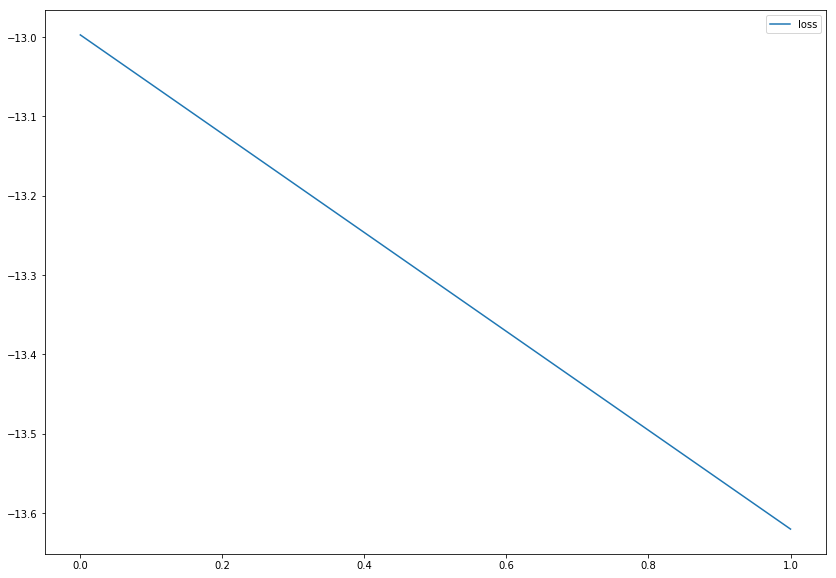

21/88 [======>.......................] - ETA: 4:14 - loss: -8.1760 - time_distributed_24_loss: 1.3481

KeyboardInterrupt: 

In [38]:
model.compile(optimizer=opt, loss=l, loss_weights=lw)

print('Ready to train')
model.fit_generator(gen_train, epochs=n_epochs, verbose=1, callbacks=cbs, validation_data=gen_val, max_queue_size=10,  workers=5)

## Some visualizations

In [ ]:
# Visualize some output on the val set 
gen = eval_generator(
    data['img_files_val'], 
    data['map_files_val'], 
    data['fix_files_val'], 
    None, 
    inp_size=model_inp_size)

examples = [next(gen) for _ in range(50)]
len(examples)

In [ ]:
images, maps, fixmaps, fixcoords = random.choice(examples)

print("maps size", len(maps), maps[0].shape)

batch = 0
preds = model.predict(images[0])[0][batch]

times = [500, 3000, 5000]
print("preds size", preds.shape)
n_times = len(preds)
assert len(times) == n_times
batch_sz = len(preds)
copy=0
# n_col, n_row = n_times + 2, batch_sz

# plt.figure(figsize=[16,10*batch_sz])

plt.imshow(reverse_preprocess(np.squeeze(images[0])))
plt.title("original image %d" % batch)
plt.show()

plt.figure(figsize=[16, 10])
n_row=n_times
n_col=2

for time in range(n_times): 

#         plt.subplot(n_row, n_col, batch*n_col+1)
#         plt.imshow(reverse_preprocess(images[batch]))
#         plt.title('Original')

    plt.subplot(n_row,n_col,time*n_col+1)
    plt.imshow(maps[time])
    plt.title('Gt %dms' % times[time])

    plt.subplot(n_row,n_col,time*n_col+2)
    # print("preds time sahpe", preds[time].shape)
    plt.imshow(np.squeeze(preds[time]))
    plt.title('Prediction %dms' % times[time])

plt.show()
    
# plt.show()

# Evaluate

In [ ]:
if True: 
    W = "../models/ckpt/mdsem_mit1003/mit1003_6bc4kl-3cc-10nss_ep12_valloss-28.7681.hdf5"
    model.load_weights(W)

In [ ]:
fix_as_mat

In [ ]:
gen = eval_generator(
    img_files_val, 
    [map_files_val[0]], 
    [fix_files_val[0]], 
    None, 
    inp_size=(shape_r, shape_c),
    fix_as_mat=fix_as_mat,
    fix_key=fix_key, 
    fixcoord_filetype='mat'
)
#get_stats(model, gen, blur=True, mode='simple', n=False, imsize=(480, 620))
get_stats_oneduration(model, gen, blur=7, mode='singlestream', start_at=None)
pass

In [ ]:
img_files_test, _, _, _, _, _, _, _ = load_datasets_multiduration('mit300', times=times, bp=bp)

In [ ]:
#img_path_test = "/mnt/localssd2/predimportance/predimportance_shared/datasets/cat2000/testStimuli/"
savedir = "../models/pred/mdsem_mit1003/mit1003_6bc4kl-3cc-10nss_ep12_valloss-28.7681/"
predict_and_save(model, img_files_test, inp_size=(shape_r, shape_c), savedir=savedir, blur=7, test_img_base_path="", ext="jpeg")